### РОССИЙСКИЙ УНИВЕРСИТЕТ ДРУЖБЫ НАРОДОВ

#### Факультет физико-математических и естественных наук  
#### Кафедра математического моделирования и искусственного интеллекта

## ОТЧЕТ ПО КОНТРОЛЬНОЙ РАБОТЕ № 8


### Дисциплина: Методы машинного обучения

##### Студент:  Миронов Дмитрий
##### Группа:   НПИ-02-21

## Москва 2024
***

### Вариант №20

###Индивидуальное задание

1. Набор данных stl10 с изменением разрешения до 72x72
2. Классы с метками 2,4,5,7,9
3. Требования к архитектуре сети MLP:
Функциональный API при создании
Функция потерь: разреженная категориальная кросс-энтропия
Кол-во скрытых слоев 6
Кол-во нейронов 50 в каждом нечетном скрытом слое, 40 в каждом четном скрытом слое
Использование слоев с регуляризацией L2
4. Требования к архитектуре сети трансформер:
Функция потерь: категориальная кросс-энтропия
5. Показатель качества многоклассовой классификации:
максимальная точность классов, где точность (precision) класса равна доле правильных предсказаний для всех точек, относимых классификатором к этому классу.


1.	Загрузите заданный в индивидуальном задании набор данных с изображениями из Tensorflow Datasets с разбиением на обучающую, валидационную и тестовую выборки. Если при дальнейшей работе с данными возникнет нехватка вычислительных ресурсов, то разрешение изображений можно уменьшить.  

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import random
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.metrics import precision_score

In [76]:
# Загрузка набора данных с разбиением на обучающую, валидационную и тестовую выборки
(ds_train, ds_val, ds_test) = tfds.load('stl10', split=['train[:80%]', 'train[80%:]', 'test'], as_supervised=True)

# Преобразование изображений к разрешению 72x72
IMG_HEIGHT = 72
IMG_WIDTH = 72

def format_image(image, label):
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    return image, label

ds_train = ds_train.map(format_image)
ds_val = ds_val.map(format_image)
ds_test = ds_test.map(format_image)

# Преобразование в DataFrame
def ds_to_dataframe(dataset):
    images = []
    labels = []
    for image, label in tfds.as_numpy(dataset):
        images.append(image)
        labels.append(label)
    df = pd.DataFrame({'image': images, 'label': labels})
    return df

df_train = ds_to_dataframe(ds_train)
df_val = ds_to_dataframe(ds_val)
df_test = ds_to_dataframe(ds_test)

# Проверка формы DataFrame
df_train.shape, df_val.shape, df_test.shape

((4000, 2), (1000, 2), (8000, 2))

2.	Оставьте в наборе изображения, указанных в индивидуальном задании, и визуализируйте по одному изображению из каждого класса, подписывая изображение меткой класса.

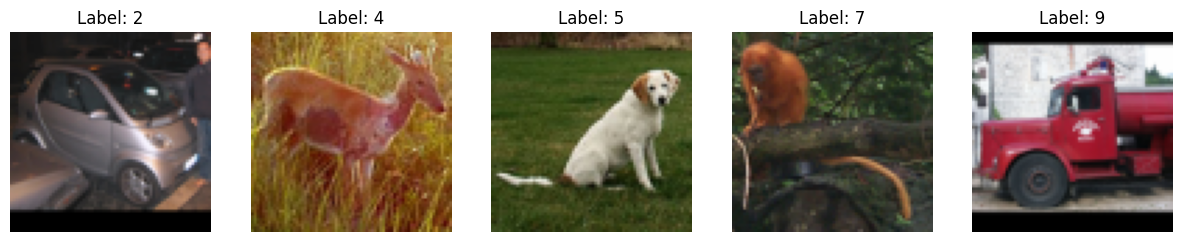

In [77]:
TARGET_CLASSES = [2, 4, 5, 7, 9]

def filter_classes(image, label):
    return tf.reduce_any(tf.equal(label, TARGET_CLASSES))

ds_train = ds_train.filter(filter_classes)
ds_val = ds_val.filter(filter_classes)
ds_test = ds_test.filter(filter_classes)

# Подсчет количества элементов в каждом наборе данных
num_train = tf.data.experimental.cardinality(ds_train).numpy()
num_val = tf.data.experimental.cardinality(ds_val).numpy()
num_test = tf.data.experimental.cardinality(ds_test).numpy()

# Перемешивание наборов данных
ds_train = ds_train.shuffle(buffer_size=num_train)
ds_val = ds_val.shuffle(buffer_size=num_val)
ds_test = ds_test.shuffle(buffer_size=num_test)

# Визуализация одного изображения из каждой метки
def visualize_images(dataset, target_classes):
    class_images = {}
    for image, label in tfds.as_numpy(dataset):
        if label in target_classes and label not in class_images:
            class_images[label] = image
        if len(class_images) == len(target_classes):
            break

    plt.figure(figsize=(15, 5))
    for i, label in enumerate(target_classes):
        plt.subplot(1, len(target_classes), i + 1)
        plt.imshow(class_images[label].astype('uint8'))
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.show()

# Визуализация изображений из обучающей выборки
visualize_images(ds_train, TARGET_CLASSES)


3.	Постройте нейронные сети различных архитектур (MLP, CNN, RNN, трансформер) для задачи многоклассовой классификации изображений (архитектуры и требования к сетям указаны в индивидуальном задании), используя функции потерь, указанные в индивидуальном задании. Подберите такие параметры, как функции активации, оптимизатор, начальная скорость обучения, размер мини-пакета и др. самостоятельно, обеспечивая обучение нейронных сетей. Обучайте нейронные сети с использованием валидационной выборки, сформированной в п. 1. Останавливайте переобучение нейронных сетей в случае роста потерь на валидационной выборке на нескольких эпохах обучения подряд.  

In [78]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models, regularizers, optimizers

# Гиперпараметры
IMG_HEIGHT = 72
IMG_WIDTH = 72
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
num_classes = 10  # STL-10 имеет 10 классов
l2_lambda = 0.01


# Преобразование изображений к разрешению 72x72
def format_image(image, label):
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    return image, label

ds_train = ds_train.map(format_image)
ds_val = ds_val.map(format_image)
ds_test = ds_test.map(format_image)

# Функция для подготовки данных
AUTOTUNE = tf.data.experimental.AUTOTUNE

def prepare(ds, shuffle=False):
    ds = ds.map(lambda x, y: (x / 255.0, y), num_parallel_calls=AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.batch(32)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare(ds_train, shuffle=True)
val_ds = prepare(ds_val)

# Создание модели MLP
def create_mlp():
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Flatten()(inputs)

    # Скрытые слои
    for i in range(6):
        if i % 2 == 0:
            x = layers.Dense(50, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda))(x)
        else:
            x = layers.Dense(40, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda))(x)
        x = layers.Dropout(0.3)(x)

    # Выходной слой
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

# Создание и компиляция модели
mlp_model = create_mlp()
mlp_model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Обучение модели с использованием обратного вызова для ранней остановки
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = mlp_model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=[early_stopping])


Epoch 1/50
63/63 [==============================] - 6s 20ms/step - loss: 4.7465 - accuracy: 0.1896 - val_loss: 3.8677 - val_accuracy: 0.2444
Epoch 2/50
63/63 [==============================] - 3s 17ms/step - loss: 3.5532 - accuracy: 0.2145 - val_loss: 3.0780 - val_accuracy: 0.3136
Epoch 3/50
63/63 [==============================] - 3s 17ms/step - loss: 2.9237 - accuracy: 0.2374 - val_loss: 2.6060 - val_accuracy: 0.2933
Epoch 4/50
63/63 [==============================] - 4s 28ms/step - loss: 2.5437 - accuracy: 0.2638 - val_loss: 2.1993 - val_accuracy: 0.3279
Epoch 5/50
63/63 [==============================] - 3s 14ms/step - loss: 2.3233 - accuracy: 0.2872 - val_loss: 2.0309 - val_accuracy: 0.3401
Epoch 6/50
63/63 [==============================] - 3s 16ms/step - loss: 2.1410 - accuracy: 0.2882 - val_loss: 1.8743 - val_accuracy: 0.3035
Epoch 7/50
63/63 [==============================] - 3s 17ms/step - loss: 1.9874 - accuracy: 0.2922 - val_loss: 1.7515 - val_accuracy: 0.3381
Epoch 8/50
63

In [98]:
# Преобразование меток в one-hot encoding для трансформера
def one_hot_encode(ds):
    def _one_hot(image, label):
        label = tf.one_hot(label, num_classes)
        return image, label
    return ds.map(_one_hot)

train_ds_one_hot = one_hot_encode(train_ds)
val_ds_one_hot = one_hot_encode(val_ds)

# Определение пользовательского Transformer Block
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = models.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim)]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Определение модели Transformer
def create_transformer_model():
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs)

    # Патчинг изображений
    patch_size = 6
    patches = layers.Conv2D(128, patch_size, patch_size)(x)
    patches = layers.Reshape((-1, 128))(patches)

    # Трансформер блоки
    transformer_block = TransformerBlock(embed_dim=128, num_heads=4, ff_dim=512)
    for _ in range(4):
        patches = transformer_block(patches)

    # Пулинг и финальная классификация
    x = layers.GlobalAveragePooling1D()(patches)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

# Создание и компиляция модели
transformer_model = create_transformer_model()
transformer_model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

# Обучение модели с использованием обратного вызова для ранней остановки
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_transformer = transformer_model.fit(train_ds_one_hot, epochs=50, validation_data=val_ds_one_hot, callbacks=[early_stopping])

Epoch 1/50
63/63 [==============================] - 14s 82ms/step - loss: 2.1583 - accuracy: 0.1901 - val_loss: 1.6712 - val_accuracy: 0.2037
Epoch 2/50
63/63 [==============================] - 5s 55ms/step - loss: 1.7760 - accuracy: 0.2066 - val_loss: 1.6258 - val_accuracy: 0.2220
Epoch 3/50
63/63 [==============================] - 6s 64ms/step - loss: 1.7060 - accuracy: 0.2031 - val_loss: 1.6322 - val_accuracy: 0.1833
Epoch 4/50
63/63 [==============================] - 5s 55ms/step - loss: 1.6790 - accuracy: 0.1891 - val_loss: 1.6164 - val_accuracy: 0.2037
Epoch 5/50
63/63 [==============================] - 6s 58ms/step - loss: 1.6599 - accuracy: 0.2016 - val_loss: 1.6204 - val_accuracy: 0.2220
Epoch 6/50
63/63 [==============================] - 6s 64ms/step - loss: 1.6480 - accuracy: 0.1971 - val_loss: 1.6257 - val_accuracy: 0.1853
Epoch 7/50
63/63 [==============================] - 5s 56ms/step - loss: 1.6411 - accuracy: 0.2051 - val_loss: 1.6361 - val_accuracy: 0.1833


4.	Вычислите и выведите в отчете матрицы ошибок нейронных сетей (tf.math.confusion_matrix) для обучающей и тестовой выборок.

In [99]:
# MLP predictions
train_predictions_mlp = np.argmax(mlp_model.predict(train_ds), axis=1)
test_predictions_mlp = np.argmax(mlp_model.predict(val_ds), axis=1)

# Transformer predictions
train_predictions_transformer = np.argmax(transformer_model.predict(train_ds), axis=1)
test_predictions_transformer = np.argmax(transformer_model.predict(val_ds), axis=1)

# Extracting labels from datasets
train_labels = np.concatenate([y.numpy() for _, y in train_ds], axis=0)
test_labels = np.concatenate([y.numpy() for _, y in val_ds], axis=0)

# Compute confusion matrices
conf_matrix_train_mlp = tf.math.confusion_matrix(labels=train_labels, predictions=train_predictions_mlp)
conf_matrix_test_mlp = tf.math.confusion_matrix(labels=test_labels, predictions=test_predictions_mlp)

conf_matrix_train_transformer = tf.math.confusion_matrix(labels=train_labels, predictions=train_predictions_transformer)
conf_matrix_test_transformer = tf.math.confusion_matrix(labels=test_labels, predictions=test_predictions_transformer)

# Print confusion matrices
print("Confusion Matrix for MLP (Training Data):\n", conf_matrix_train_mlp)
print("\nConfusion Matrix for MLP (Testing Data):\n", conf_matrix_test_mlp)
print("\nConfusion Matrix for Transformer (Training Data):\n", conf_matrix_train_transformer)
print("\nConfusion Matrix for Transformer (Test Data):\n", conf_matrix_test_transformer)


16/16 [==============================] - 1s 17ms/step
Confusion Matrix for MLP (Training Data):
 tf.Tensor(
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0  33   0 272   0   0  14   0  90]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0  33   0 274   0   0   5   0  98]
 [  0   0  40   0 272   0   0  11   0  76]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0  23   0 278   0   0   8   0  82]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0  31   0 254   0   0   9   0 106]], shape=(10, 10), dtype=int32)

Confusion Matrix for MLP (Testing Data):
 tf.Tensor(
[[ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  4  0 59  0  0  1  0 27]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  5  0 58  0  0  2  0 25]
 [ 0  0  4  0 72  0  0  6  0 19]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  5  0 77  0  0  2  0 25]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  5  0 67  0  0  5  0 23]], shape=(10, 10), dtype=int32)

Confusion Matri

5.	Визуализируйте кривые обучения построенных моделей для показателей потерь на обучающей и валидационной выборках на одном рисунке в зависимости от эпохи обучения, подписывая оси и рисунок и создавая легенду. Используйте для визуализации относительные потери (потери, деленные на начальные потери на первой эпохе).

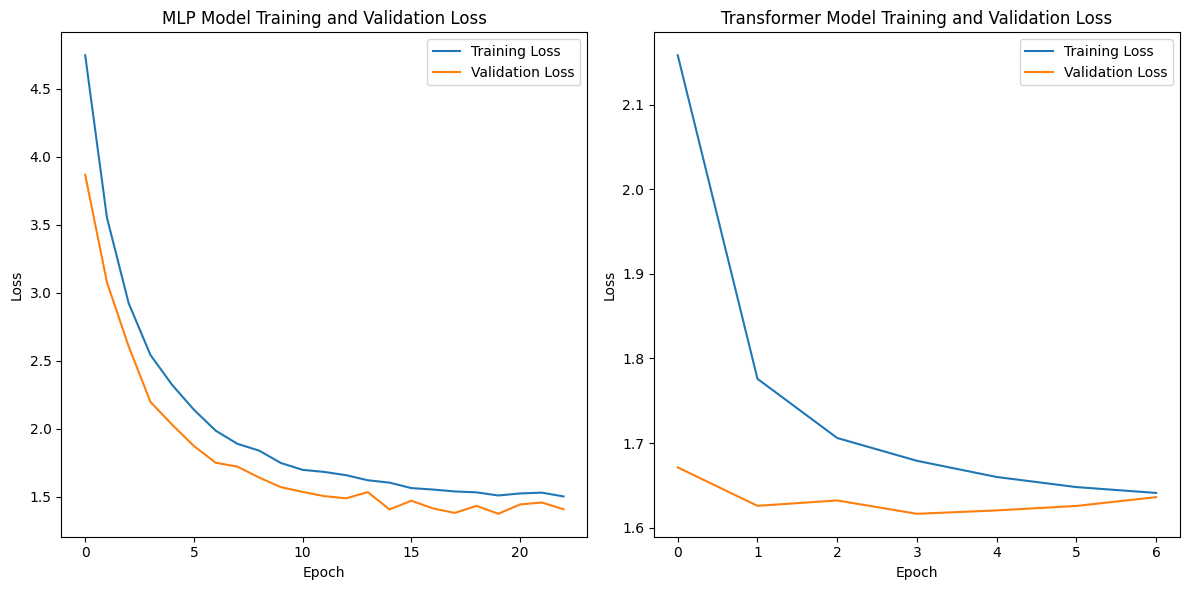

In [100]:
import matplotlib.pyplot as plt

# Создание первого графика для MLP модели
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('MLP Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Создание второго графика для модели Transformer
plt.subplot(1, 2, 2)

plt.plot(history_transformer.history['loss'], label='Training Loss')
plt.plot(history_transformer.history['val_loss'], label='Validation Loss')

plt.title('Transformer Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


6.	Оцените качество многоклассовой классификации нейронными сетями на тестовой выборке при помощи показателя качества, указанного в индивидуальном задании, и выведите название нейронной сети с лучшим качеством.  

In [101]:
# Подготовка тестового набора данных
test_ds = prepare(ds_test)
test_ds_one_hot = one_hot_encode(test_ds)

# Получение предсказаний для тестовой выборки
mlp_predictions = mlp_model.predict(test_ds)
transformer_predictions = transformer_model.predict(test_ds_one_hot)

# Преобразование предсказаний в метки классов
mlp_pred_labels = np.argmax(mlp_predictions, axis=1)
transformer_pred_labels = np.argmax(transformer_predictions, axis=1)

# Получение истинных меток
test_labels = np.concatenate([y for x, y in test_ds], axis=0)

# Расчет точности (precision) для каждого класса
mlp_precision = precision_score(test_labels, mlp_pred_labels, average=None)
transformer_precision = precision_score(test_labels, transformer_pred_labels, average=None)

# Определение максимальной точности классов для каждой модели
mlp_max_precision = np.max(mlp_precision)
transformer_max_precision = np.max(transformer_precision)

# Вывод результатов
print(f"Максимальная точность классов для MLP: {mlp_max_precision}")
print(f"Максимальная точность классов для Transformer: {transformer_max_precision}")

if mlp_max_precision > transformer_max_precision:
    print("MLP имеет лучшую максимальную точность классов.")
else:
    print("Transformer имеет лучшую максимальную точность классов.")


125/125 [==============================] - 7s 18ms/step
Максимальная точность классов для MLP: 0.2727272727272727
Максимальная точность классов для Transformer: 0.2
MLP имеет лучшую максимальную точность классов.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
